In [1]:
!pip install lightgbm==3.2.1
!pip install scikit-optimize

     |████████████████████████████████| 2.0 MB 5.3 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 100 kB 3.4 MB/s 


In [2]:
import sys
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import lightgbm as lgb

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [11]:
var = 'phosphorus'

indata = pd.read_excel(('/content/gdrive/MyDrive/SBP_vars/data_'+ var + '.xlsx'),
                       sheet_name="Sheet4",
                       thousands=(","), header=0)

labels = np.array(indata[var])

features = indata[["B02_mean", "B03_mean", "B04_mean", "B05_mean", "B06_mean",
                   "B07_mean", "B08_mean", "B09_mean", "B11_mean", "B12_mean", "B8A_mean", "NDVI",
                   "GNDVI", "SR", "NDRE", "NDWI", "PREC", "TEMP", "RAD", "Elevation", "slope", 
                   "Morfologia", "AUX", "Lat", "Lon"]]
 

features = np.array(features)


cv_m = joblib.load('/content/gdrive/MyDrive/SBP_vars/cross_validation_folds/cv_farm_' + 
                   var +'.joblib')

import time
t0= time.clock()

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

dftrainLGB = lgb.Dataset(data = features, label = labels)
                         
# cv_results = lgb.cv(
#         params,
#         dftrainLGB,
#         num_boost_round=10000,
#         nfold=9,
#         early_stopping_rounds=10,
#         stratified=False
#         )

# cv_ = cv_results['l2-mean']
# cv_ = np.sqrt(cv_)

# print(np.min(cv_))


# param_grid = {
#     'num_leaves': [31, 127],
#     'reg_alpha': [0.1, 0.5],
#     'min_data_in_leaf': [30, 50, 100, 300, 400],
#     'lambda_l1': [0, 0.5, 1.5],
#     'lambda_l2': [0, 1],
#     'learning_rate': [0.01, 0.05, 0.1]
#     }

lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt',  
                                   objective='regression', 
                                   metric='mse', 
                                   silent=True,
                                   n_jobs=-1,
                                   numIterations=1000,                                    
                                   )

# gkf = model_selection.ShuffleSplit(n_splits = 9, random_state=0)


a = np.arange(50, 1001, 50)
a= np.concatenate([[1, 2, 3,4, 5, 10, 20, 30, 40],a])
b = np.arange(50, 501, 50)
c = np.arange(0.0, 1.1, 0.1)
d = np.arange(10, 200, 10)

params = {'n_estimators': a,
          # 'num_leaves': d,
          'reg_alpha': c,
          'min_data_in_leaf': [1, 5, 10, 30, 50, 100, 300, 400],
          'reg_lambda': c,
          'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
          }

gsearch = BayesSearchCV(estimator =lgb_estimator, search_spaces = params, n_iter=100,
                                    n_jobs=-1, cv=cv_m,
                                    verbose = 0,
                                    scoring=('neg_root_mean_squared_error'),
                                    return_train_score=True)

lgb_model = gsearch.fit(X=features, y=labels)

print(lgb_model.best_params_)

model_best = lgb_model.best_estimator_

print(lgb_model.best_params_)

print(lgb_model.cv_results_['mean_train_score'][lgb_model.best_index_], 
      lgb_model.cv_results_['mean_test_score'][lgb_model.best_index_])


sc = cross_validate(model_best, features, labels, cv=cv_m, scoring=('neg_mean_squared_error'),
                            return_train_score=True)

rmse_test = sc['test_score'] *-1
rmse_train = sc['train_score'] *-1

print(np.sqrt(np.mean(rmse_train)), np.sqrt(np.mean(rmse_test)))


sc = cross_validate(model_best, features, labels, cv=cv_m, scoring=('r2'),
                            return_train_score=True)

r2_test = sc['test_score']
r2_train = sc['train_score']

print(np.sqrt(np.mean(abs(r2_train))), np.sqrt(abs(np.mean(r2_test))))


# pickle.dump(forest_bayes_search, open(
#     'results_random/results_'+ a[0:a.find('.')] + '_' + var + '.pkl', 
#     "wb"))

lab=["B02_mean", "B03_mean", "B04_mean", "B05_mean", "B06_mean",
                   "B07_mean", "B08_mean", "B09_mean", "B11_mean", "B12_mean", "B8A_mean", "NDVI",
                   "GNDVI", "SR", "NDRE", "NDWI", "PREC", "TEMP", "RAD", "Elevation", "slope", 
                   "Morfologia", "AUX", "Lat", "Lon"]



df = pd.DataFrame(model_best.feature_importances_,  columns=['rn_biomass'])

dd= model_best.feature_importances_
dd = dd* 100
dd = dd.reshape(-1,1)

expmf = np.concatenate([ np.array(lab).reshape(-1,1),dd], axis=1)

df = pd.DataFrame(expmf, columns=['feature', 'Feature Importance'])
df['Feature Importance'] = df['Feature Importance'].astype(float)


t1 = time.clock() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)

joblib.dump(lgb_model, '/content/gdrive/MyDrive/SBP_vars/results_farm/results_'+ 'lgb_' + var + '.joblib')

clf = joblib.load('/content/gdrive/MyDrive/SBP_vars/results_farm/results_'+ 'lgb_' + var + '.joblib')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


[LightGBM] [Warning] Unknown parameter: numIterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
OrderedDict([('learning_rate', 0.005), ('min_data_in_leaf', 30), ('n_estimators', 800), ('reg_alpha', 0.4), ('reg_lambda', 0.1)])
OrderedDict([('learning_rate', 0.005), ('min_data_in_leaf', 30), ('n_estimators', 800), ('reg_alpha', 0.4), ('reg_lambda', 0.1)])
-0.5450316778135744 -0.7283654435701751
[LightGBM] [Warning] Unknown parameter: numIterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: numIterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Unknown parameter: numIterations
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
562/60

9.366666666666667

Text(0.05, 0.76, '$r^{2}$ = 0.593')

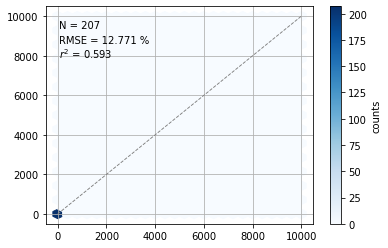

In [ ]:
y_pred = cross_val_predict(estimator=model_best, 
                            X=features, y=labels, 
                            n_jobs= -1, cv=cv_m)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ex = [0, 10000, 0, 10000]
hb = plt.hexbin(x=labels, y=y_pred, gridsize=25, cmap='Blues', extent=ex)
plt.plot([0, 10000], [0, 10000], color='tab:gray', 
      linestyle = '--', zorder = 10, linewidth=0.9)
plt.grid(b=True)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.text(0.05, 0.90,'N = ' + str( len(labels) ),transform=ax.transAxes)
plt.text(0.05, 0.83,'RMSE = ' + str( np.round(forest_bayes_search.cv_results_['mean_test_score'][forest_bayes_search.best_index_] *-1, 3)) + " %",transform=ax.transAxes)
plt.text(0.05, 0.76,'$r^{2}$ = ' + str( np.round(abs(np.sqrt(np.mean(r2_test))), 3)), transform=ax.transAxes)
